# Game of Thrones NLP

In [303]:
# GENERAL
import numpy as np
import pandas as pd
import re
import glob
from collections import Counter


# GRAPHICS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# NLP
from nltk import word_tokenize
from nltk import bigrams
from nltk import trigrams
from nltk import ngrams
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import collocations
import spacy
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# MODELING
from sklearn import metrics, tree, linear_model, neighbors, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier

## 0. Research questions

### Can we train a model to identify which GoT character is saying a line from the show?

### Can we use NLP to identify major characters' "catchphrases" (distinct ngrams)?

### What insights can we get from analyzing the sentiment of characters' lines?

## 1. Load, clean GoT script data

### NOTE: all scripts acquired from genius.com. Some formatting for Season 1 scripts was required before loading.

Now we have a way of generating n-grams for each character. Once we load all episode transcripts we can make better use of this.

## 1. Load & clean GoT scripts - produce df for analysis

In [143]:
def generate_dialogue_dataframe(path):
    '''
    For a given path containing files composed of Game of Thrones dialogue, populate_dataframe
    generates a dataframe containing all the characters, the lines they spoke, and the words in each line.
    Also generates season, episode, from file name.
    Returns df['Characters', 'Lines', 'Words', 'Season', 'Episode'], sorted by season, episode
    '''

    # Create df to be returned
    df = pd.DataFrame()

    # Read files
    files = glob.glob(path)
    print(len(files), "read.")

    for file in files:
        # Get season, episode from filename
        episode = file[-6:-4]
        season = file[-9:-7]
        
        # Load script 
        original_script = open(file).read() # Load files
        script = original_script.split("\n\n") # Create script

        # Populate script lines (only lines containing ":")
        script_lines = []
        for i in range(0,len(script)):
            if ":" in script[i]:
                script_lines.append(script[i])
    #     print(file, "\nAll lines:", len(script), "->", "Dialogue lines:", len(script_lines))

        # Remove all parentheses, square brackets from Lines, Characters
        p = 0
        sb = 0
        ast = 0
        for i in range(0, len(script_lines)):
            while "(" in script_lines[i]:
#                 print(script_lines[i])
                script_lines[i] = re.sub("\(.+?\)"," ", script_lines[i])
                p += 1
            while "[" in script_lines[i]:
#                 print(script_lines[i])
                script_lines[i] = re.sub("\[.+?\]"," ", script_lines[i])
                sb += 1
            while "*" in script_lines[i]:
#                 print(script_lines[i])
                script_lines[i] = re.sub("\*.+?\*"," ", script_lines[i])
                ast += 1  
#         print(p, "parentheses removed.", sb, "square brackets removed.", ast, "*s removed.")

        # Separate lines into character, line
        characters = []
        lines = []
        for line in script_lines:
            if len(line.split(":")) > 1: # If the line can be split...
                characters.append(line.split(":")[0].strip().strip("\n")) # Strip leading (& trailing) newlines
                lines.append(line.split(":")[1].strip()) # Strip leading (& trailing) whitespace

        # Add characters, lines to dataframe df
        df_temp = pd.DataFrame()
        df_temp["Characters"] = characters
        df_temp["Lines"] = lines
        df_temp["Season"] = [season]*len(lines)
        df_temp["Episode"] = [episode]*len(lines)
        df = df.append(df_temp)
#         print("df shape:", df.shape)
        
    # df cleanup
    cut_words = ["CUT TO", "EXT", "INT"] # remove cut_words
    for cut_word in cut_words:
        df = df[df['Characters'] != cut_word]
    df.sort_values(by=['Season', 'Episode'], inplace=True) # Sort by season, episode
    
    # Character consolidation (for characters with different names)
    replacement_names = {'HOUND':'SANDOR', 'THE HOUND':'SANDOR', 'LITTLEFINGER':'BAELISH', 'MAESTER LUWIN':'LUWIN',\
                        'BARRISTAN SELMY':'BARRISTAN', 'EDDISON TOLLETT':'EDDISON', 'KHAL DROGO':'DROGO',\
                         'JON SNOW':'JON', 'KRAZNYS MO NAKLOZ':'KRAZNYS', 'RATTLESHIRT':'LORD OF BONES',\
                         'ROOSE BOLTON':'ROOSE'}
    for name in replacement_names:
        df['Characters'] = df['Characters'].replace(name,replacement_names[name])

    real_chars = df['Characters'].str.isupper() == True # Remove non-caps characters
    df = df[real_chars]
    
    # Add word count for each line
    word_count = lambda x: len(x.split())
    df['Words'] = df['Lines'].apply(word_count)
    
    return df

In [144]:
# Subset top n characters from df (df_top_n)
def n_most_lines(df, n):
    '''
    Subsets the n characters with the most lines
    Returns df_top_n
    '''
    top_n_characters = pd.DataFrame(data=df['Characters'].value_counts()).index[0:n] # Get the top n characters
    df_top_n = pd.DataFrame(data=df[df['Characters'].isin(top_n_characters)]) # Subset df

    return df_top_n

In [145]:
# Run the function generate_dialogue_dataframe for all according files
path = 'GoT_NLP data/GoT_S**E**.txt'
df = generate_dialogue_dataframe(path)
print("df_shape:", df.shape)
df.head()

58 read.
df_shape: (19224, 5)


,Characters,Lines,Season,Episode,Words
0,WAYMAR ROYCE,What d’you expect? They’re savages. One lot st...,01,01,24
1,WILL,I’ve never seen wildlings do a thing like this...,01,01,21
2,WAYMAR ROYCE,How close did you get?,01,01,5
3,WILL,Close as any man would.,01,01,5
4,GARED,We should head back to the wall.,01,01,7


### 1.1 Preliminary analysis: lines and words by character

Now we have a df consisting of character names and lines for each character. Let's get a sorted series of line counts for each character.

In [146]:
def lines_and_words(df):
    '''
    Produces a sorted df with line and word counts for each character.
    returns df_lines_and_words
    '''

    # Get total lines for each character
    lines_by_char = pd.DataFrame(data=df['Characters'].value_counts())
    lines_by_char.rename(columns={"Characters":"Total Lines"}, inplace=True)

    # Get total lines for each character
    words_by_char = pd.DataFrame(data = df.groupby(by=['Characters']).sum().values,\
        index=df.groupby(by=['Characters']).sum().index.values, columns=["Total Words"])

    # Create df_lines_and_words
    df_lines_and_words = pd.concat([lines_by_char, words_by_char], axis=1, sort=True).sort_values(by="Total Lines",\
        ascending=False)
    
    # Get words per line for each character
    df_lines_and_words['Words per Line'] = df_lines_and_words['Total Words'].values/\
        df_lines_and_words['Total Lines'].values
    df_lines_and_words['Words per Line'] = round(df_lines_and_words['Words per Line'], 0)
        
    return df_lines_and_words

Let's also subset the df for the top 100 characters with the most lines.

In [147]:
# Apply n_most_lines, lines_and_words, to generate a df of the characters with the most lines. 
max_chars = 100

df_top_chars = n_most_lines(df, max_chars)
df_lines_and_words = lines_and_words(df_top_chars)

Let's graph the line counts for the first 20 characters.

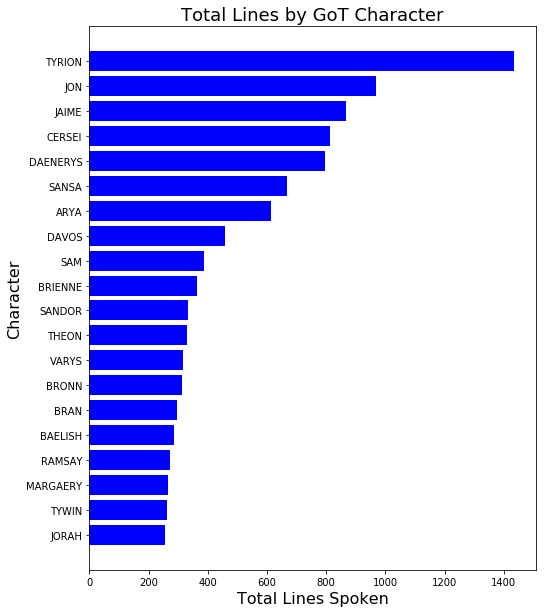

In [148]:
# Graph total lines per character
max_chars = 20
df_lines_and_words.sort_values(by="Total Lines", ascending=False, inplace=True)

plt.figure(figsize=(8,10))
plt.barh(width = df_lines_and_words['Total Lines'].values[0:max_chars],\
         y=df_lines_and_words.index[0:max_chars], color='blue')
plt.gca().invert_yaxis()
plt.xlabel('Total Lines Spoken', fontsize=16)
plt.ylabel('Character', fontsize=16)
plt.title(f'Total Lines by GoT Character', fontsize=18)
plt.show()

Let's get a sorted series of word counts for each character and graph the number of words spoken for the top 20 most verbose characters.

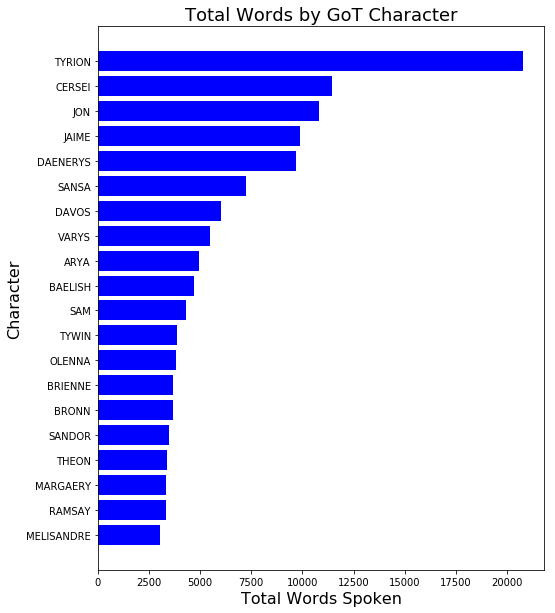

In [149]:
# Graph total words per character
max_chars = 20
df_lines_and_words.sort_values(by="Total Words", ascending=False, inplace=True)

plt.figure(figsize=(8,10))
plt.barh(width = df_lines_and_words['Total Words'].values[0:max_chars],\
         y=df_lines_and_words.index[0:max_chars], color='blue')
plt.gca().invert_yaxis()
plt.xlabel('Total Words Spoken', fontsize=16)
plt.ylabel('Character', fontsize=16)
plt.title(f'Total Words by GoT Character', fontsize=18)
plt.show()

There's some slight difference here between the two graphs - clearly some characters have more words per lines than others.

Which characters have the most words per line? Let's check the top 50 characters with most lines.

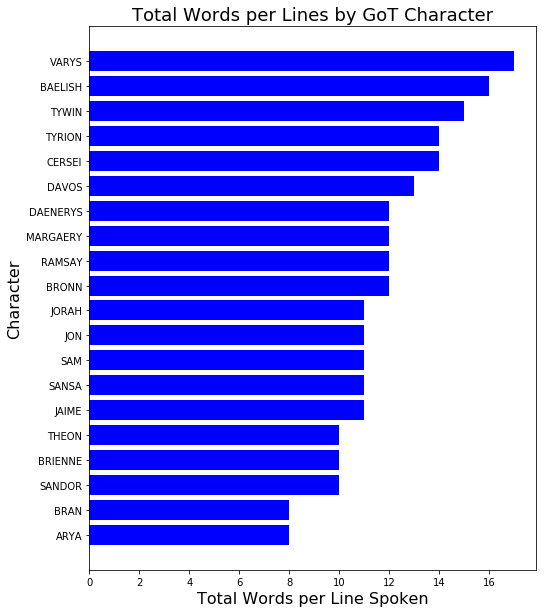

In [150]:
# Graph total Words per Line for top max_char characters with the most Lines
max_char=50
df_top_chars = n_most_lines(df, 50)
df_lines_and_words = lines_and_words(df_top_chars)

df_top_chars = n_most_lines(df, max_chars) # Get top max_chars characters
df_lines_and_words = lines_and_words(df_top_chars) # Get lines & words for characters with most lines
df_lines_and_words.sort_values(by="Words per Line", ascending=False, inplace=True) # Sort by Words per Line

plt.figure(figsize=(8,10))
plt.barh(width = df_lines_and_words['Words per Line'].values[0:max_chars],\
         y=df_lines_and_words.index[0:max_chars], color='blue')
plt.gca().invert_yaxis()
plt.xlabel('Total Words per Line Spoken', fontsize=16)
plt.ylabel('Character', fontsize=16)
plt.title(f'Total Words per Lines by GoT Character', fontsize=18)
plt.show()

## 2. Add Sentiment Analysis to df

In [151]:
# LOAD NLP MODEL
nlp = spacy.load('en_core_web_lg')

In [152]:
def add_sentiment_analysis(df):
    """
    Takes in a df containing "Lines" and performs sentiment analysis on each block of text.
    Returns an updated df with four sentiment (Vader) columns for each line.
    Saves the updated df to file
    """
    # Add four NLP coloums
    if "Compound" not in df.columns:
        df['Polarity'] = None
        df['Positive'] = None
        df['Negative'] = None
        df['Neutral'] = None
        df['Compound'] = None
    
    # Instantiate Vader analyzer
    analyzer = SentimentIntensityAnalyzer()
        
    # Populate polarity (TextBlob)
    pol = lambda x: round(TextBlob(x).sentiment.polarity,3)
    
    df['Polarity'] = df['Lines'].apply(pol)

    # Populate Vader sentiment columns
    pos = lambda x: round(analyzer.polarity_scores(x)['pos'],3)
    neg = lambda x: round(analyzer.polarity_scores(x)['neg'],3)
    neu = lambda x: round(analyzer.polarity_scores(x)['neu'],3)
    compound = lambda x: round(analyzer.polarity_scores(x)['compound'],3)

    df['Positive'] = df['Lines'].apply(pos)
    df['Negative'] = df['Lines'].apply(neg)    
    df['Neutral'] = df['Lines'].apply(neu)
    df['Compound'] = df['Lines'].apply(compound)
    
    # Save to file
    df.to_csv("df_backup_GoT.csv")
    print(f"Successfully performed sentiment analysis.")
    return df

In [167]:
def graph_sentiment_by_char(df):
    
    # GRAPH TEXTBLOB VALUES    
    df.sort_values(by='Polarity', ascending=True, inplace=True) # Sort df by Textblob values
    characters = df.index.values
 
    plt.figure(figsize=(12,20))
    plt.title("TextBlob sentiments")
    plt.barh(width=df['Polarity'].values, y=characters)
    plt.show
    
    # GRAPH VADER VALUES
    df.sort_values(by='Compound', ascending=True, inplace=True) # Sort df by Textblob values
    characters = df.index.values

    plt.figure(figsize=(12,20))
    plt.title("VADER sentiments (Compound)")
    plt.barh(width=df['Compound'].values, y=characters, color="blue")
    plt.show
    
    plt.figure(figsize=(12,20))
    plt.title("VADER sentiments (Positive/Negative)")
    plt.barh(width=-df['Negative'].values, y=characters, color="red")
    plt.barh(width=df['Positive'].values, y=characters, color="green")
    plt.show

    return None

In [171]:
df_sent = add_sentiment_analysis(df)
df_sent.shape

Successfully performed sentiment analysis.


(19224, 10)

In [172]:
# Subset sentiment df by characters with the most lines
max_chars = 30
df_sent = n_most_lines(df_sent, max_chars)

In [173]:
# Get mean sentiment for each character
df_sent_by_char = df_sent.groupby("Characters").mean()

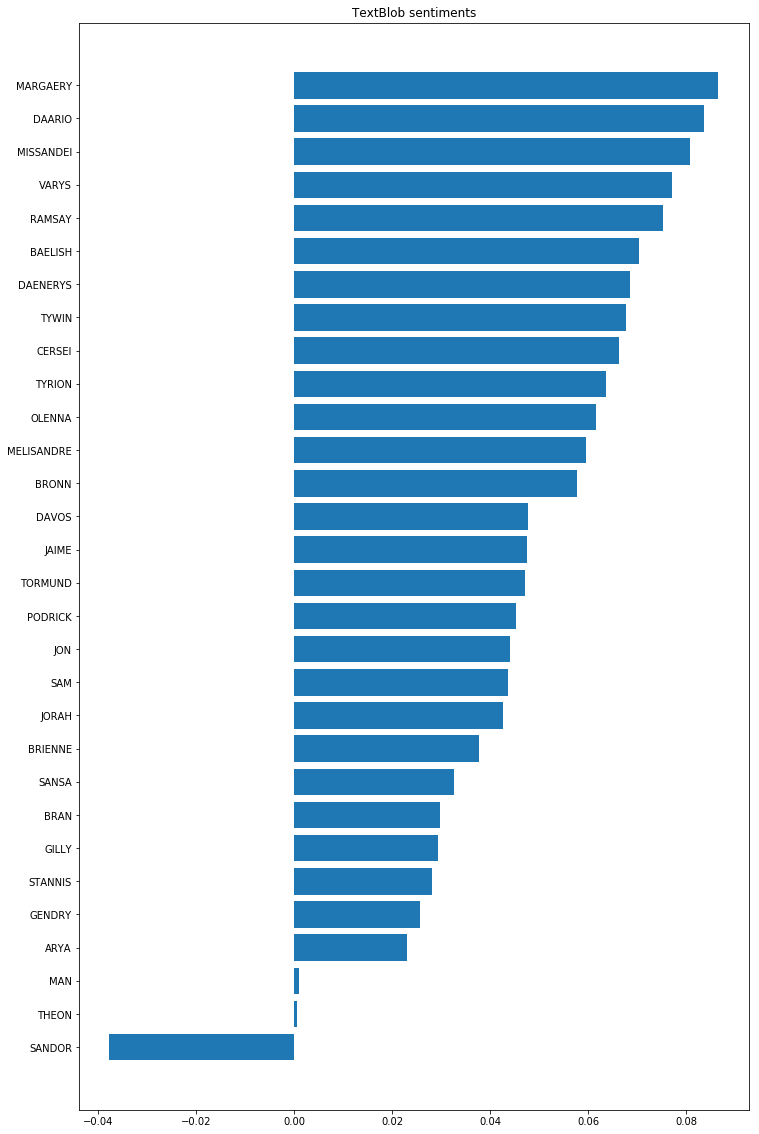

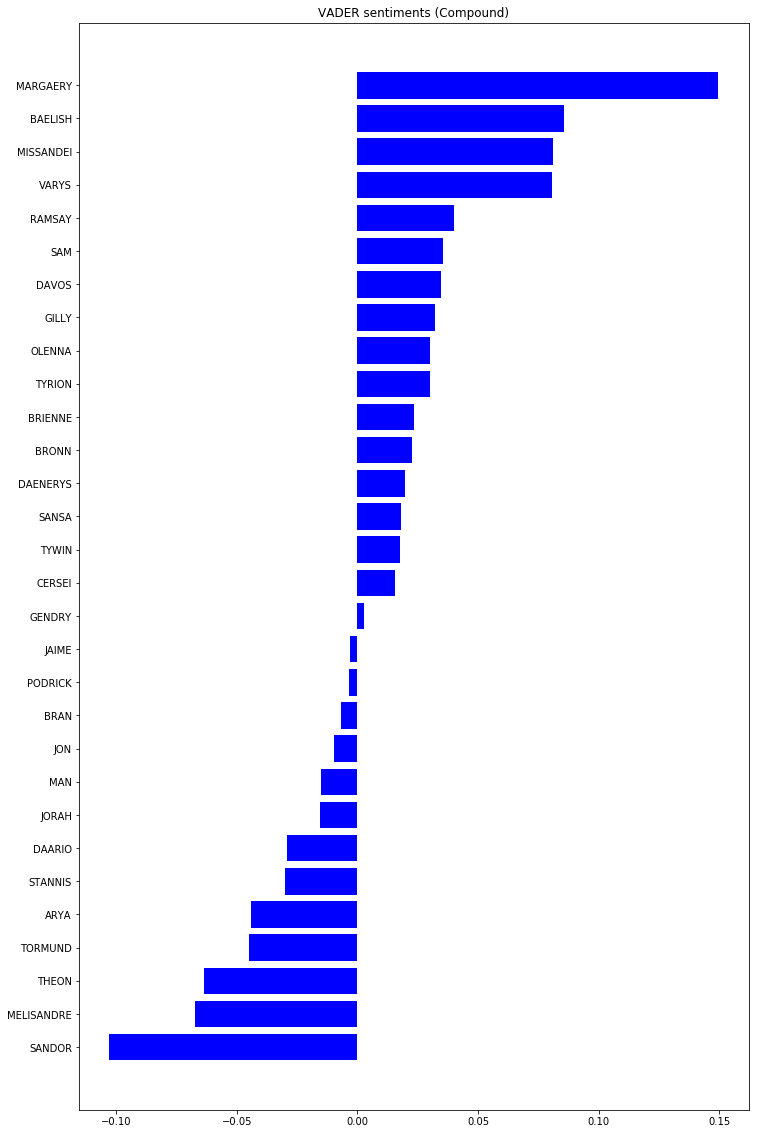

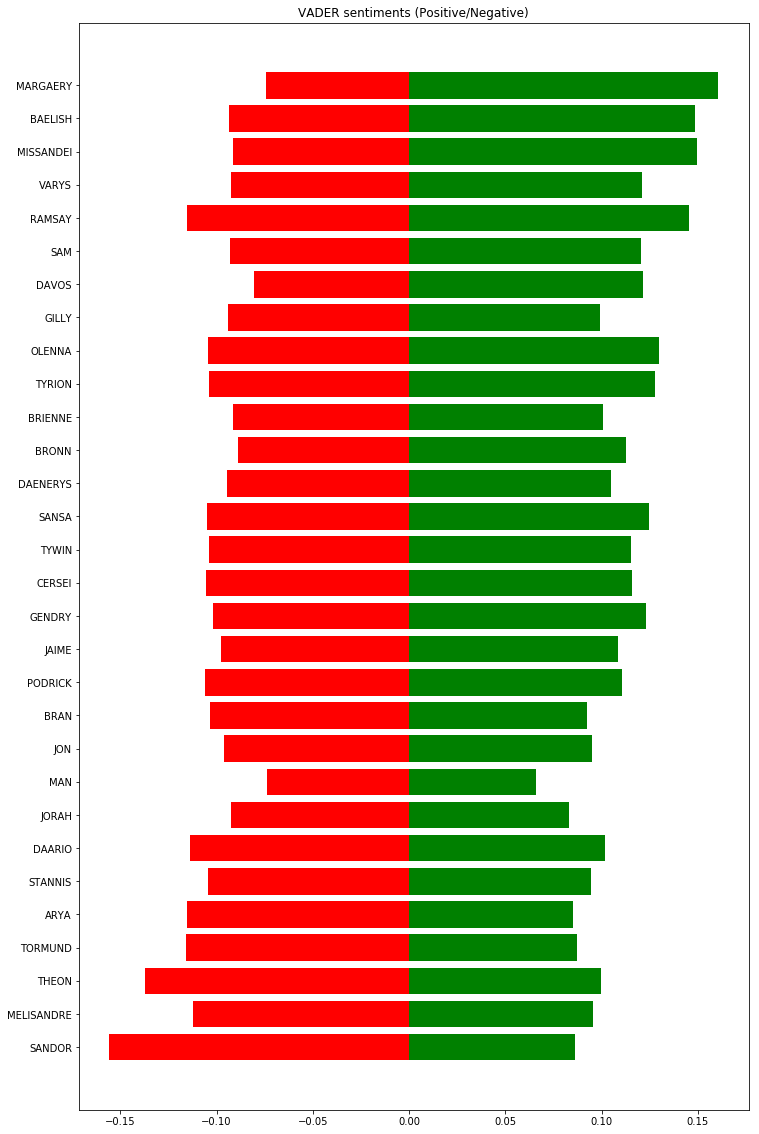

In [174]:
# Graph mean sentiment 
graph_sentiment_by_char(df_sent_by_char)

It looks like Margery Tyrell - all sunshine and roses - is the queen of positive sentiment, while the less-than-friendly Sandor Clegane has the most negative sentiment.

## 3 Find common n-grams for each character

In [316]:
# Add empty bigram, trigram, 4-gram, 5-gram columns to the df
df["Bigrams"] = ""
df["Trigrams"] = ""
df["Fourgrams"] = ""
df["Fivegrams"] = ""

In [379]:
# Use NLTK to find all bigrams, trigrams, fourgrams, fivegrams for each line
all_bigrams = []
all_trigrams = []
all_fourgrams = []
all_fivegrams = []

for i in df['Lines']:
    
    i = re.sub("[^A-Za-z ]", "", i) # Removes all non-letters, spaces from text
    i = i.lower()
    
    bgs = bigrams(i.split()) # 2-grams
    all_bigrams.append(list(bgs))
    
    tgs = trigrams(i.split()) # 3-grams
    all_trigrams.append(list(tgs))
    
    fourgrams = ngrams(i.split(), 4) # 4-grams
    all_fourgrams.append(list(fourgrams))
    
    fivegrams = ngrams(i.split(), 5) # 5-grams
    all_fivegrams.append(list(fivegrams))
    
df["Bigrams"] = all_bigrams
df["Trigrams"] = all_trigrams
df["Fourgrams"] = all_fourgrams
df["Fivegrams"] = all_fivegrams

In [380]:
# Check common bigrams, trigrams for a character (e.g. TYRION)
def get_ngrams(character, n=5):
    '''
    Gets n most common n-grams for a given character.
    Returns array of n n-grams.
    '''
    bigrams = df[df['Characters']==character]["Bigrams"].values
    trigrams = df[df['Characters']==character]["Trigrams"].values
    fourgrams = df[df['Characters']==character]["Fourgrams"].values
    fivegrams = df[df['Characters']==character]["Fivegrams"].values
    
    # Place all bigrams, trigrams for the character into a single list
    all_bigrams, all_trigrams, all_fourgrams, all_fivegrams = [], [], [], []

    # Create total list of all character n-grams
    for i in bigrams:
        all_bigrams += i
    for i in trigrams:
        all_trigrams += i
    for i in fourgrams:
        all_fourgrams += i
    for i in fivegrams:
        all_fivegrams += i

    # Get counts for all character n-grams
    bigram_counter = Counter(all_bigrams)
    trigram_counter = Counter(all_trigrams)
    fourgram_counter = Counter(all_fourgrams)  
    fivegram_counter = Counter(all_fivegrams)

    most_common_ngrams = np.array([bigram_counter.most_common(n), trigram_counter.most_common(n),\
        fourgram_counter.most_common(n), fivegram_counter.most_common(n)])
    
    return most_common_ngrams

In [405]:
# Get the 5 most common n-grams for character (e.g. YGRITTE)
char = "SANDOR"
mcn = get_ngrams(char, 20)
mcn

array([[[('i', 'dont'), 10],
        [('if', 'you'), 9],
        [('you', 'dont'), 8],
        [('in', 'the'), 8],
        [('are', 'you'), 7],
        [('do', 'you'), 7],
        [('you', 'want'), 7],
        [('kill', 'me'), 7],
        [('go', 'on'), 7],
        [('you', 'doing'), 6],
        [('you', 'think'), 6],
        [('youre', 'not'), 6],
        [('i', 'was'), 6],
        [('youve', 'got'), 6],
        [('to', 'die'), 6],
        [('you', 'do'), 6],
        [('is', 'that'), 5],
        [('that', 'it'), 5],
        [('my', 'brother'), 5],
        [('want', 'to'), 5]],

       [[('what', 'are', 'you'), 4],
        [('is', 'that', 'it'), 4],
        [('are', 'you', 'doing'), 3],
        [('worse', 'than', 'me'), 3],
        [('on', 'your', 'own'), 3],
        [('do', 'you', 'want'), 3],
        [('we', 'ask', 'the'), 3],
        [('kill', 'me', 'kill'), 3],
        [('me', 'kill', 'me'), 3],
        [('better', 'than', 'you'), 3],
        [('the', 'lord', 'of'), 3],
        [('

In [470]:
# Check how many times a phrase is used, who uses it
phrase = "chicken"

# How many times does the phrase appear?
df_temp = df[df['Lines'].str.contains(phrase, case=False)]
print(f"{phrase} is used {len(df_temp)} times")

# Who used the phrase?
display(df_temp.groupby(by='Characters').size().sort_values(ascending=False))

chicken is used 10 times


Characters
SANDOR      5
POLLIVER    2
MANCE       1
GENDRY      1
ARYA        1
dtype: int64

In [726]:
char_lines = df['Characters'].value_counts()
sorted(char_lines, reverse=True)

[1436,
 867,
 842,
 812,
 793,
 668,
 614,
 457,
 388,
 365,
 330,
 316,
 314,
 297,
 272,
 266,
 263,
 254,
 239,
 229,
 213,
 200,
 199,
 194,
 187,
 177,
 165,
 164,
 161,
 156,
 155,
 151,
 150,
 132,
 126,
 125,
 124,
 123,
 122,
 119,
 116,
 109,
 109,
 104,
 104,
 99,
 94,
 93,
 92,
 92,
 89,
 77,
 77,
 71,
 68,
 68,
 66,
 66,
 63,
 62,
 62,
 61,
 61,
 57,
 54,
 53,
 52,
 51,
 51,
 50,
 50,
 50,
 47,
 47,
 46,
 46,
 45,
 45,
 44,
 43,
 43,
 42,
 38,
 38,
 36,
 35,
 35,
 35,
 34,
 34,
 34,
 34,
 33,
 32,
 32,
 32,
 31,
 31,
 30,
 30,
 30,
 29,
 29,
 29,
 28,
 28,
 28,
 28,
 26,
 26,
 25,
 25,
 24,
 24,
 24,
 24,
 23,
 22,
 22,
 22,
 22,
 22,
 21,
 21,
 21,
 20,
 20,
 20,
 19,
 19,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,

19256 --> 16588


# 4. Plot averaged (2 eps avg?) quantity /sentiment of dialogue over the series

## oo - Code snippits

In [ ]:
# Drop blank lines
df.dropna(subset=['Lines'], inplace=True)